In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input -- Share number uncertain before 2013
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'GSF.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,689,-275,414,215,182,442,75,2566,107,...,4907,418,606,157,1303,875,2919,-81,-57,112
1,2014-03-31,1015,-610,405,56,286,369,60,2539,107,...,4875,278,852,0,1247,1024,2851,99,-41,112
2,2014-06-30,1138,-704,435,-60,240,557,63,2534,108,...,4906,354,420,0,932,1394,2906,58,-31,112
3,2014-09-30,956,-467,488,-59,196,396,92,2328,108,...,4738,433,304,0,864,1371,2804,186,-77,112
4,2014-12-31,990,-513,478,207,181,504,91,2714,109,...,5352,360,736,0,1328,1219,3130,-186,-163,112


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,112,1640,-586,1054,62,643,259,240,...,1478,12875,717,0,369,1849,3492,6390,-148,-160
37,2023-03-31,2023-04-21,112,1546,-415,1131,427,243,210,216,...,1524,13222,494,0,363,1547,3429,6195,99,-276
38,2023-06-30,2023-07-21,112,2372,-954,1419,-4,802,321,211,...,1562,13632,633,0,420,2613,3661,7573,709,-185
39,2023-09-30,2023-10-21,112,1164,-383,781,-100,286,203,202,...,1534,13076,759,0,443,2199,3606,6915,-380,-145
40,2023-12-31,2024-02-11,113,1937,-995,942,247,216,327,230,...,1502,13663,760,0,508,1777,4603,7294,-728,-186


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,112,1640,-586,1054,62,643,259,240,...,12875,717,0,369,1849,3492,6390,-148,-160,10.186402
37,2023-03-31,2023-04-21,112,1546,-415,1131,427,243,210,216,...,13222,494,0,363,1547,3429,6195,99,-276,10.221379
38,2023-06-30,2023-07-21,112,2372,-954,1419,-4,802,321,211,...,13632,633,0,420,2613,3661,7573,709,-185,10.699984
39,2023-09-30,2023-10-21,112,1164,-383,781,-100,286,203,202,...,13076,759,0,443,2199,3606,6915,-380,-145,10.483742
40,2023-12-31,2024-02-11,113,1937,-995,942,247,216,327,230,...,13663,760,0,508,1777,4603,7294,-728,-186,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,112,1640,-586,1054,62,643,259,240,...,12875,717,0,369,1849,3492,6390,-148,-160,10.186402
37,2023-03-31,2023-04-21,112,1546,-415,1131,427,243,210,216,...,13222,494,0,363,1547,3429,6195,99,-276,10.221379
38,2023-06-30,2023-07-21,112,2372,-954,1419,-4,802,321,211,...,13632,633,0,420,2613,3661,7573,709,-185,10.699984
39,2023-09-30,2023-10-21,112,1164,-383,781,-100,286,203,202,...,13076,759,0,443,2199,3606,6915,-380,-145,10.483742
40,2023-12-31,2024-02-11,113,1937,-995,942,247,216,327,230,...,13663,760,0,508,1777,4603,7294,-728,-186,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,17.529669,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,0.405136,0.594864,6.235294,2.631579,15.142857,14.666667,0.600871,0.312046,0.17526,0.432596
1,2014-02-24,17.297998,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,0.405136,0.594864,6.235294,2.631579,15.142857,14.666667,0.600871,0.312046,0.17526,0.432596
2,2014-03-03,17.761339,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,0.405136,0.594864,6.235294,2.631579,15.142857,14.666667,0.600871,0.312046,0.17526,0.432596
3,2014-03-10,17.375225,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,0.405136,0.594864,6.235294,2.631579,15.142857,14.666667,0.600871,0.312046,0.17526,0.432596
4,2014-03-17,17.529669,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,0.405136,0.594864,6.235294,2.631579,15.142857,14.666667,0.600871,0.312046,0.17526,0.432596


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,17.529669,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,14.666667,0.600871,0.312046,0.17526,0.432596,2.282934,0.987587,0.712381,1.705487,-20.451280
1,2014-02-24,17.297998,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,14.666667,0.600871,0.312046,0.17526,0.432596,2.252763,0.974535,0.702967,1.696073,-20.180998
2,2014-03-03,17.761339,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,14.666667,0.600871,0.312046,0.17526,0.432596,2.313105,1.000639,0.721796,1.714902,-20.721562
3,2014-03-10,17.375225,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,14.666667,0.600871,0.312046,0.17526,0.432596,2.262820,0.978886,0.706105,1.699211,-20.271096
4,2014-03-17,17.529669,2013-12-31,689.0,7.678571,17.75,112.0,-96.0,-0.857143,182.0,...,14.666667,0.600871,0.312046,0.17526,0.432596,2.282934,0.987587,0.712381,1.705487,-20.451280


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

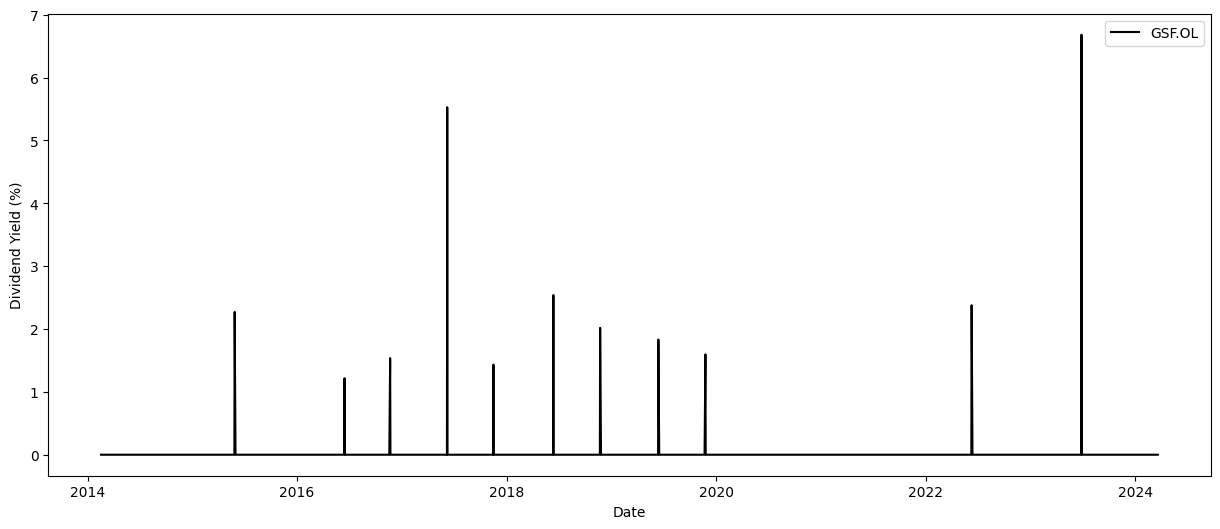

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.537572
share_price      1.000000
Name: share_price, dtype: float64


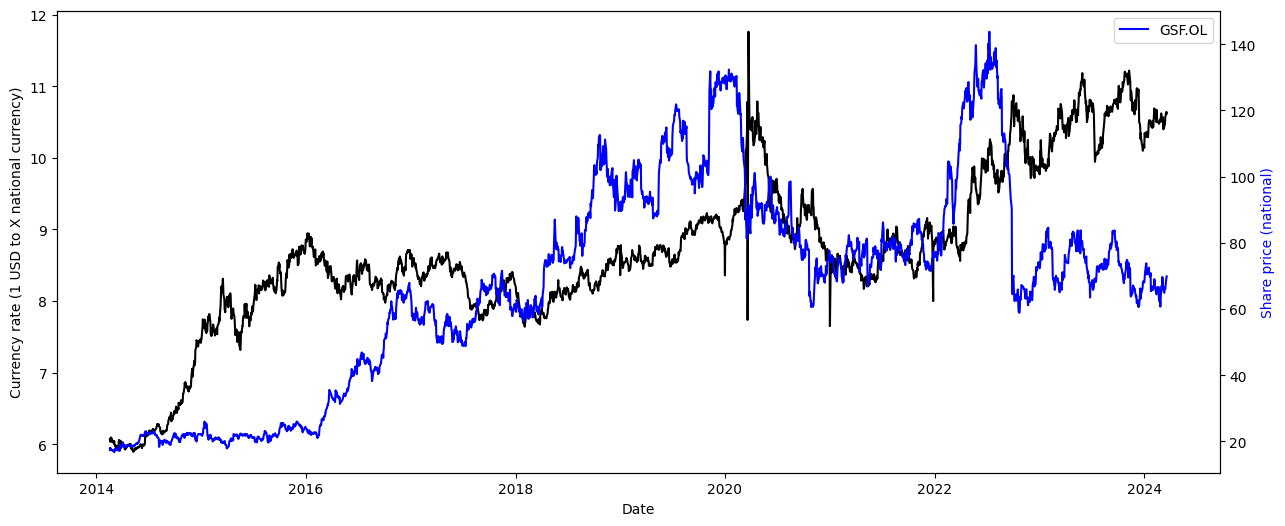

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

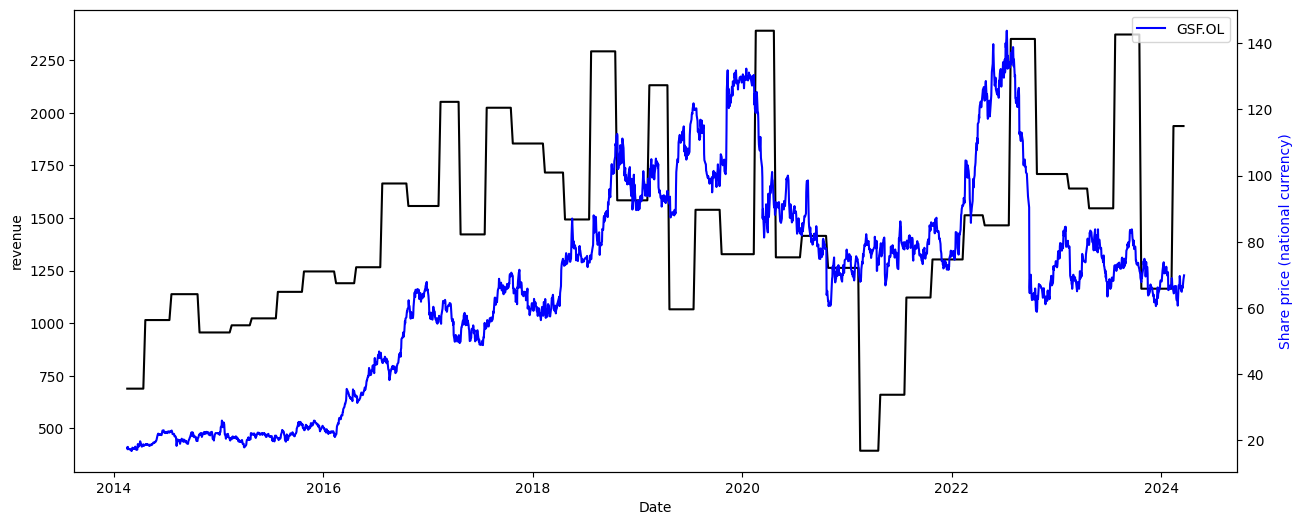

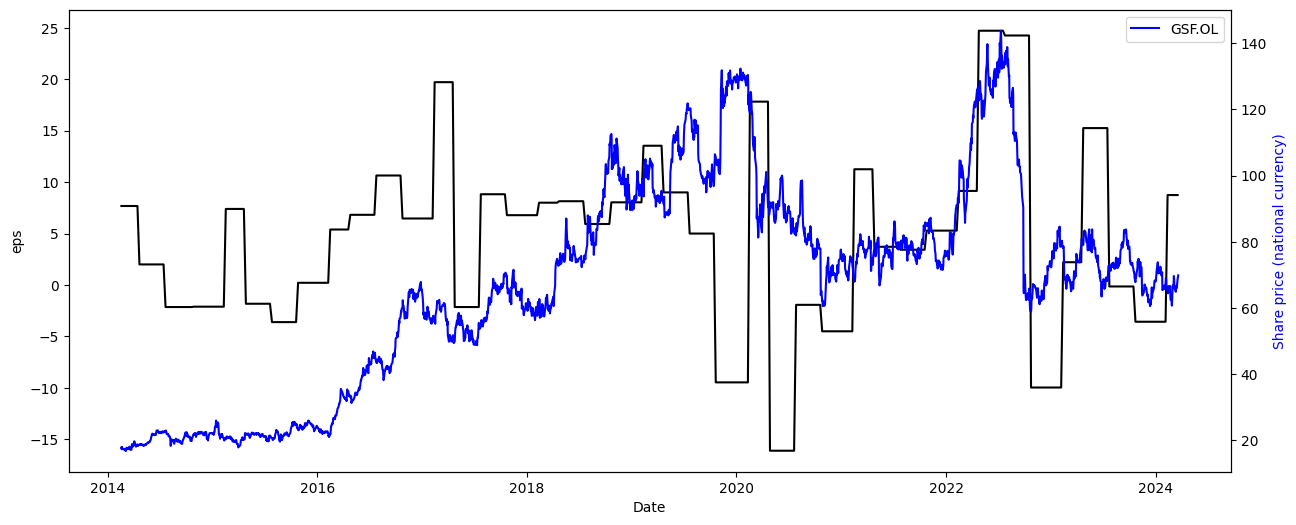

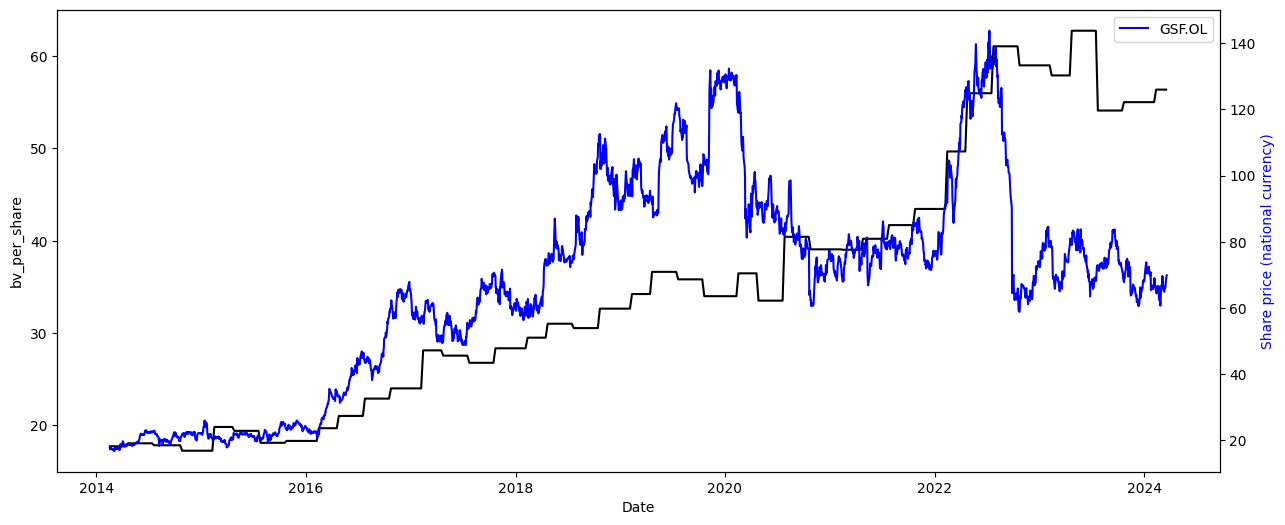

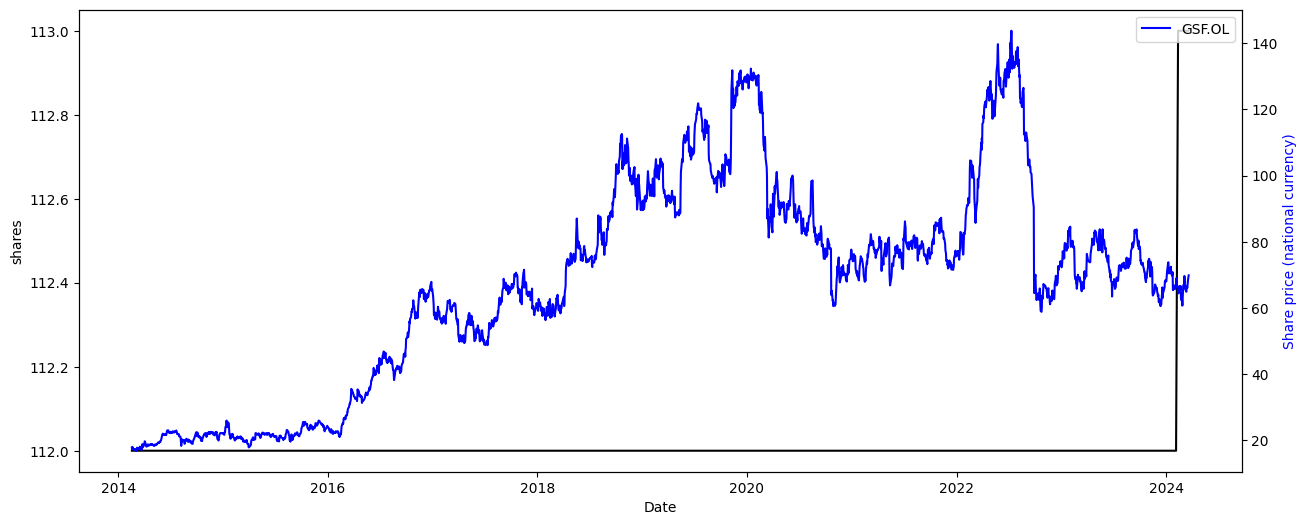

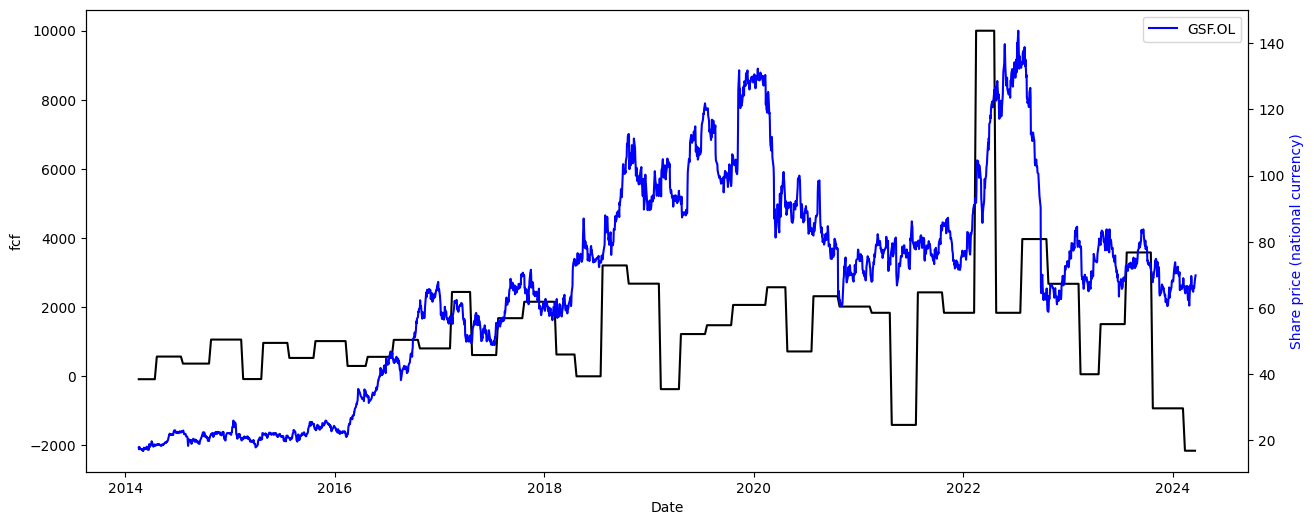

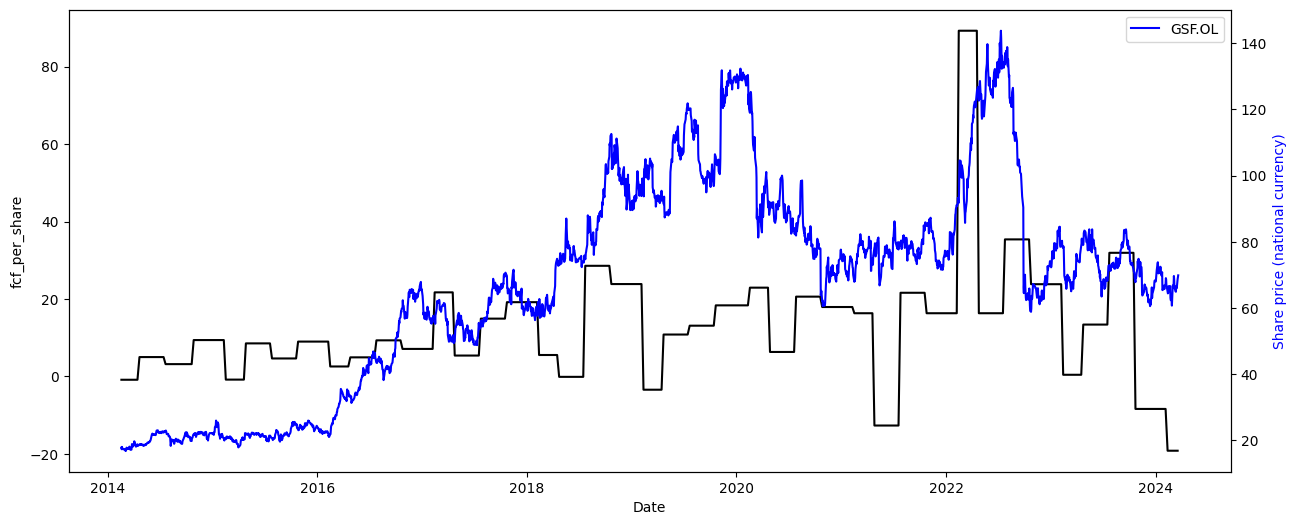

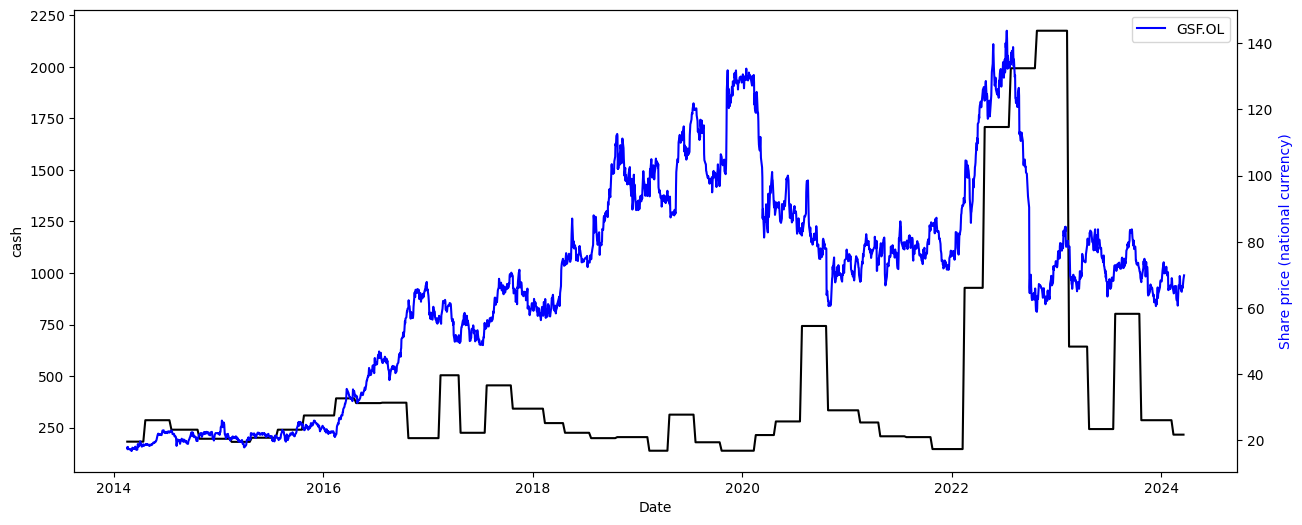

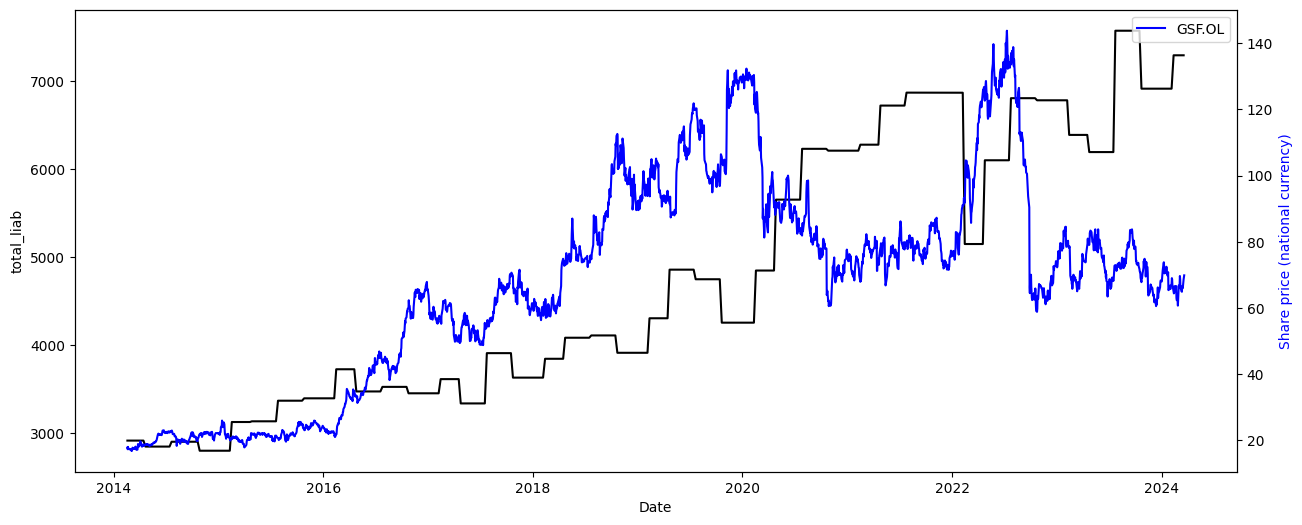

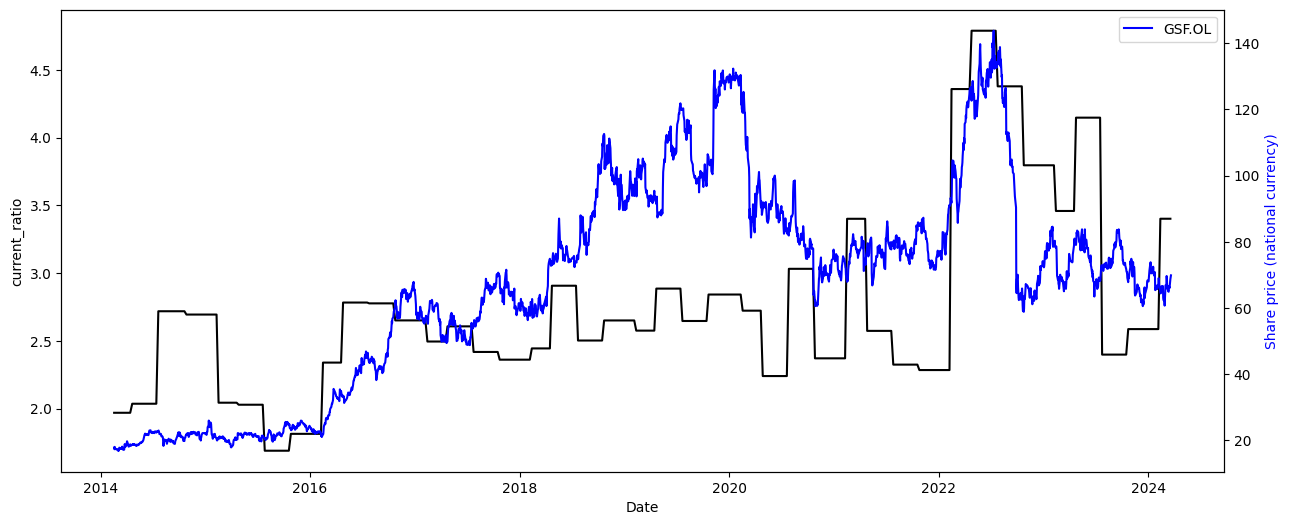

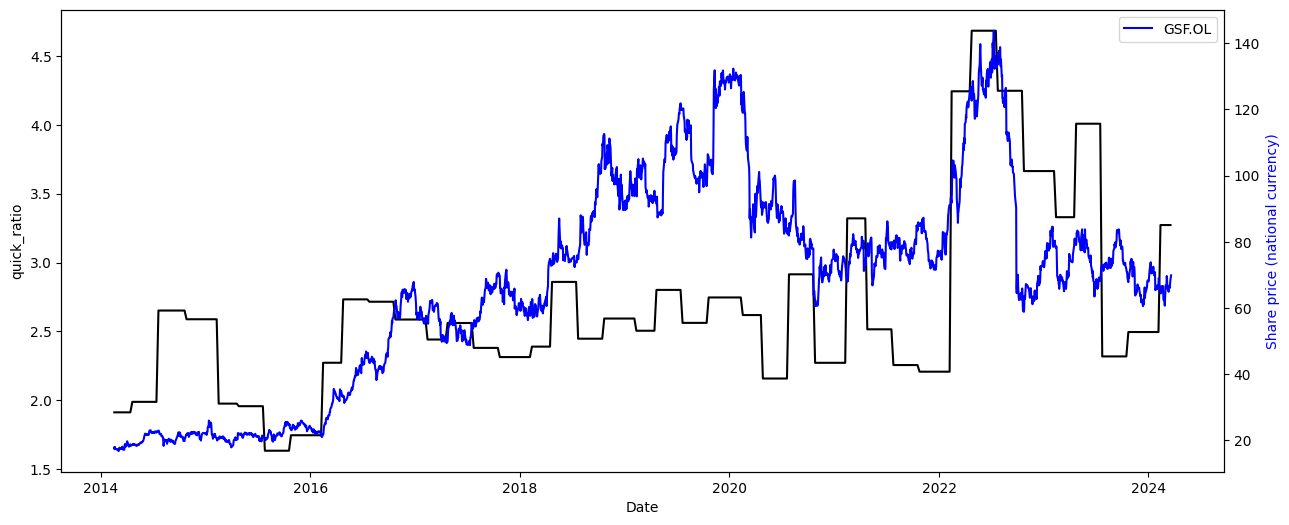

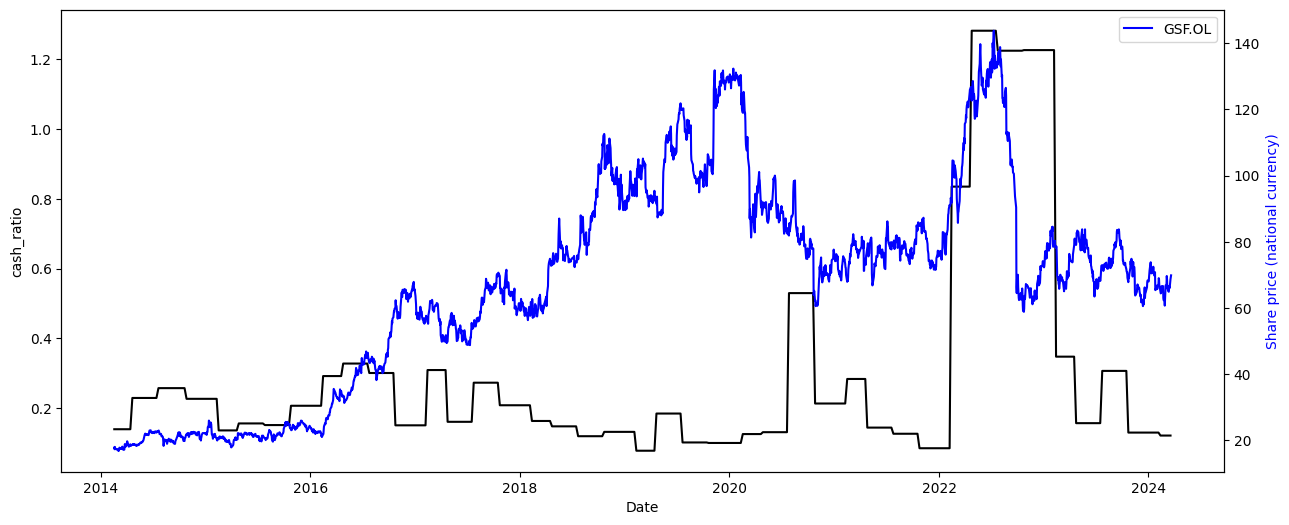

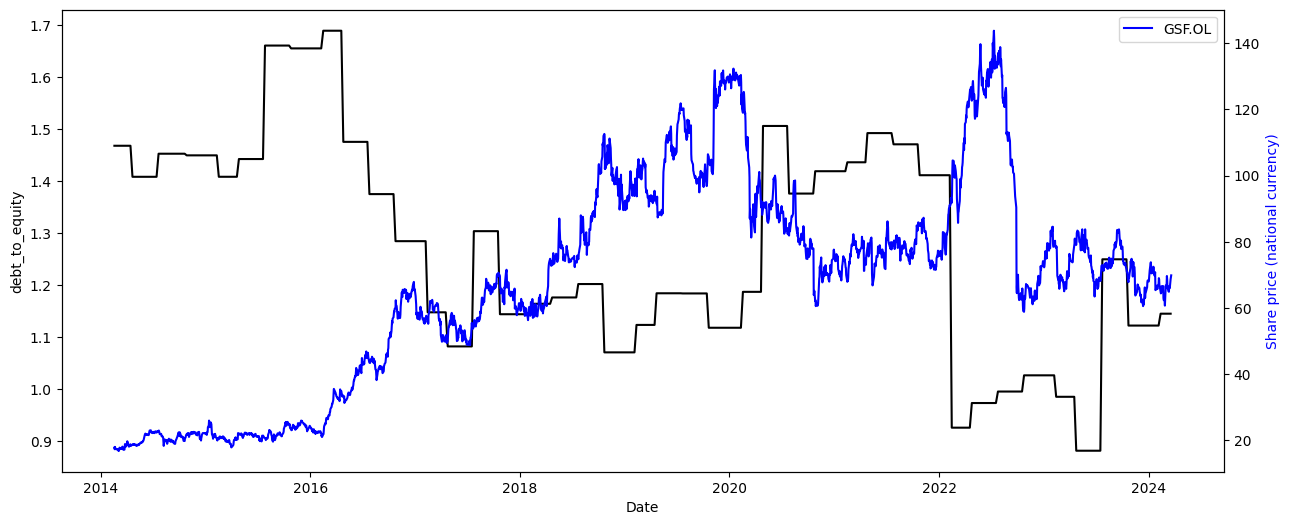

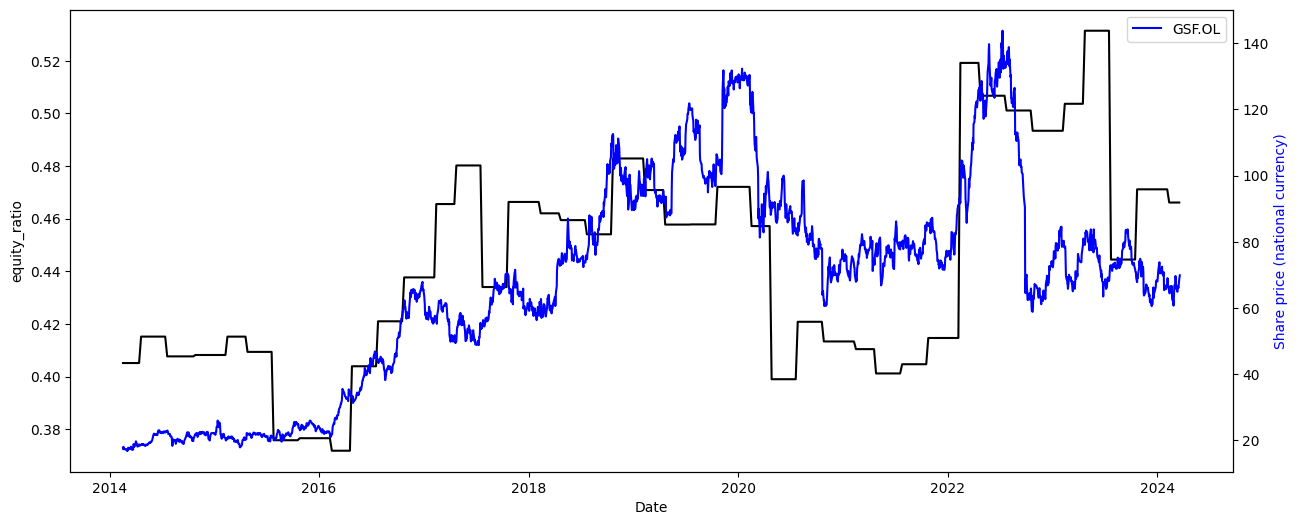

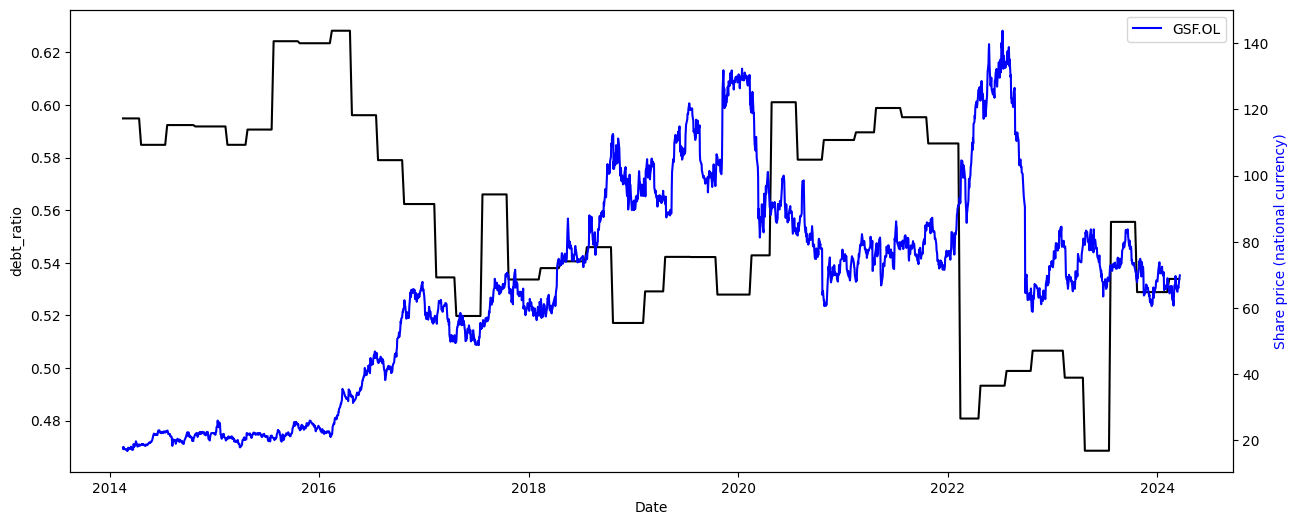

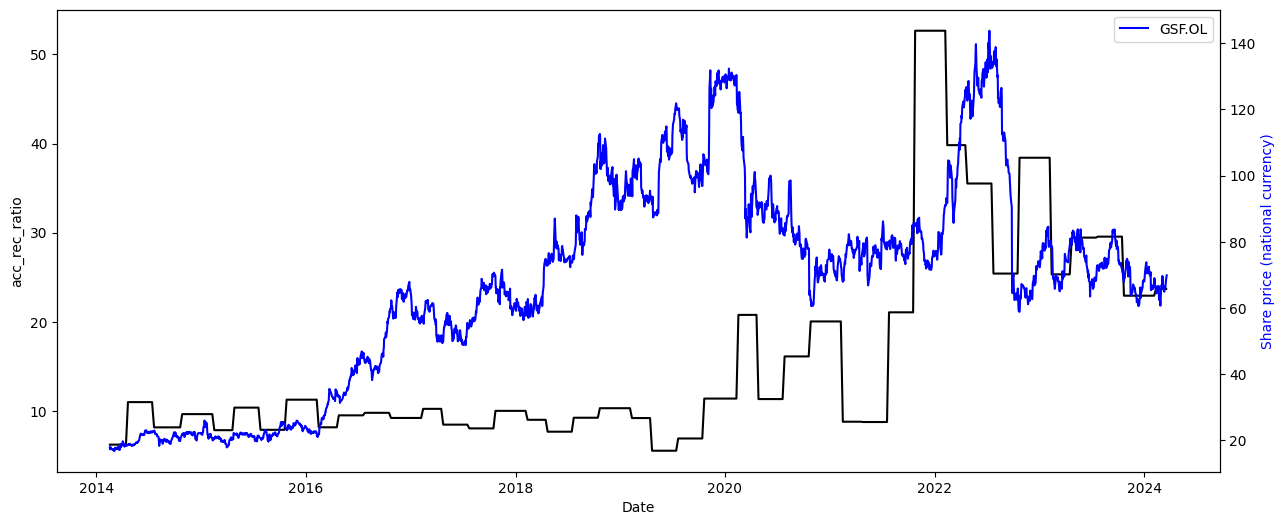

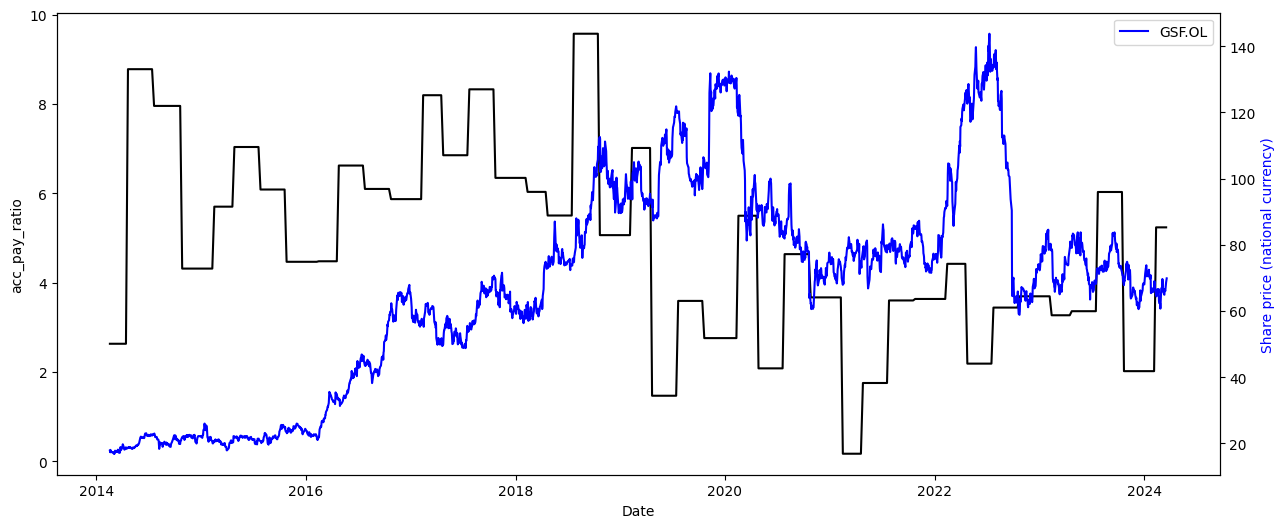

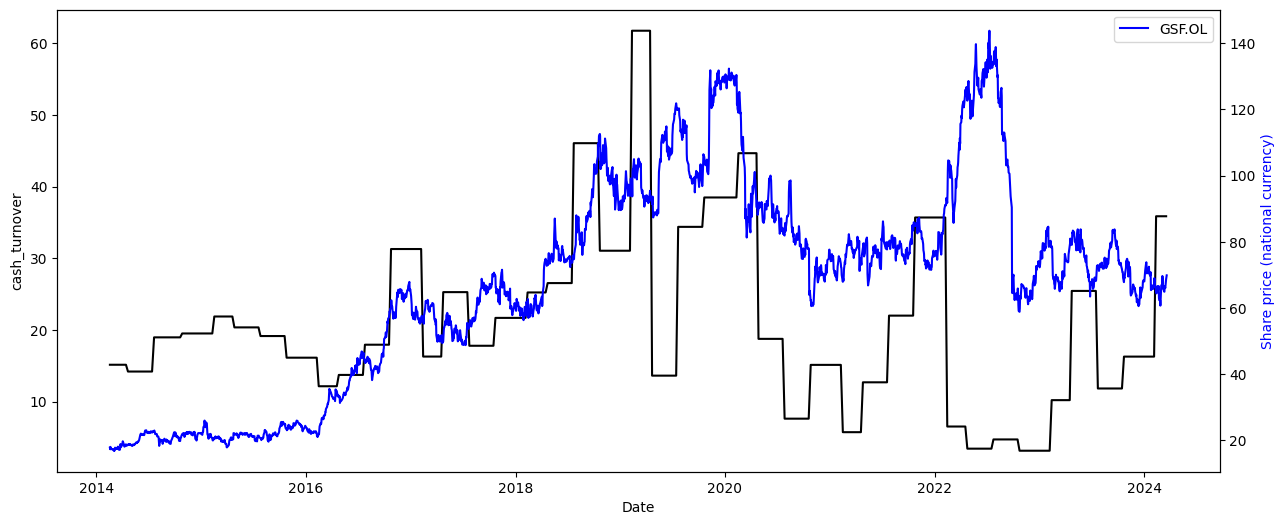

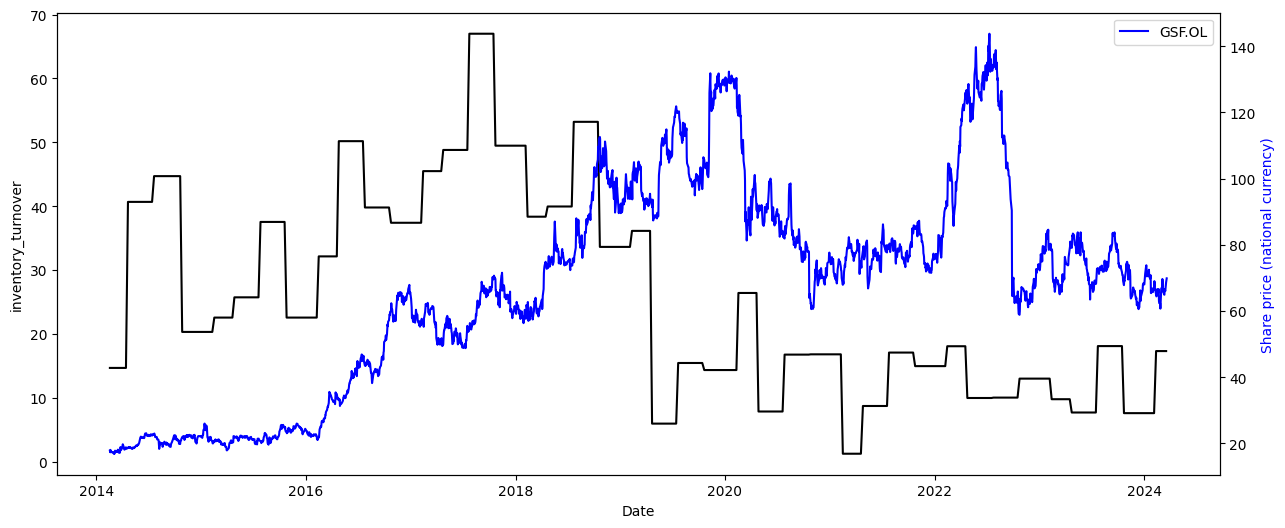

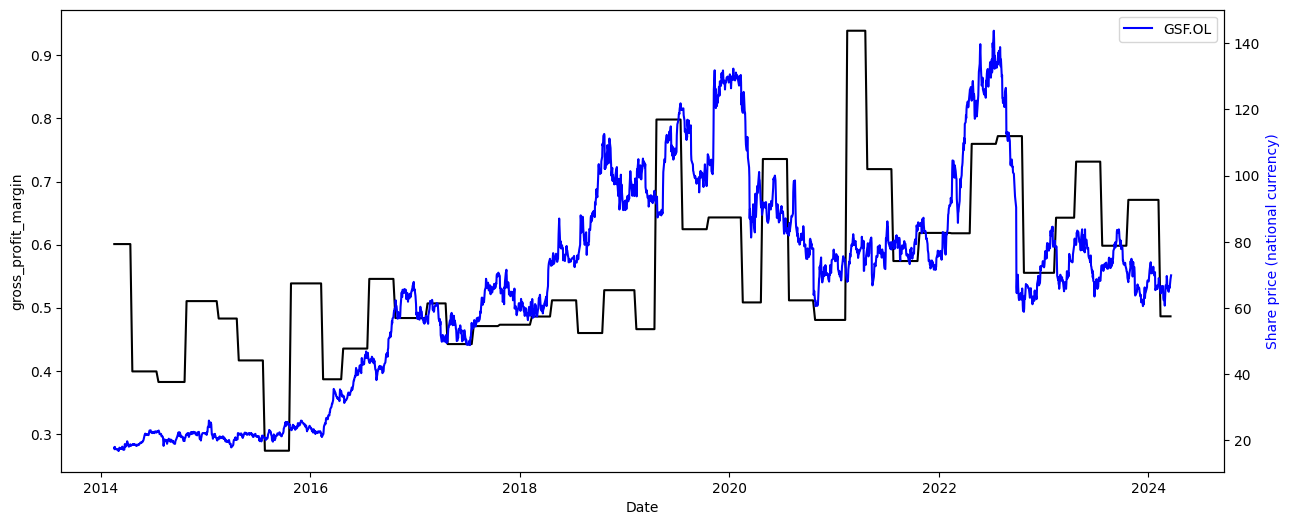

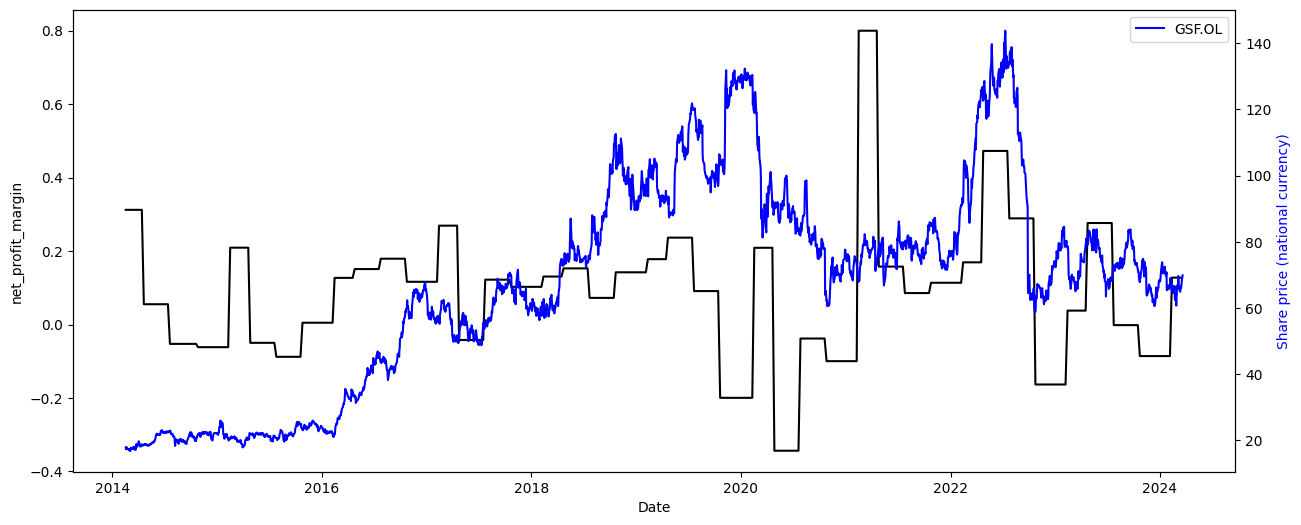

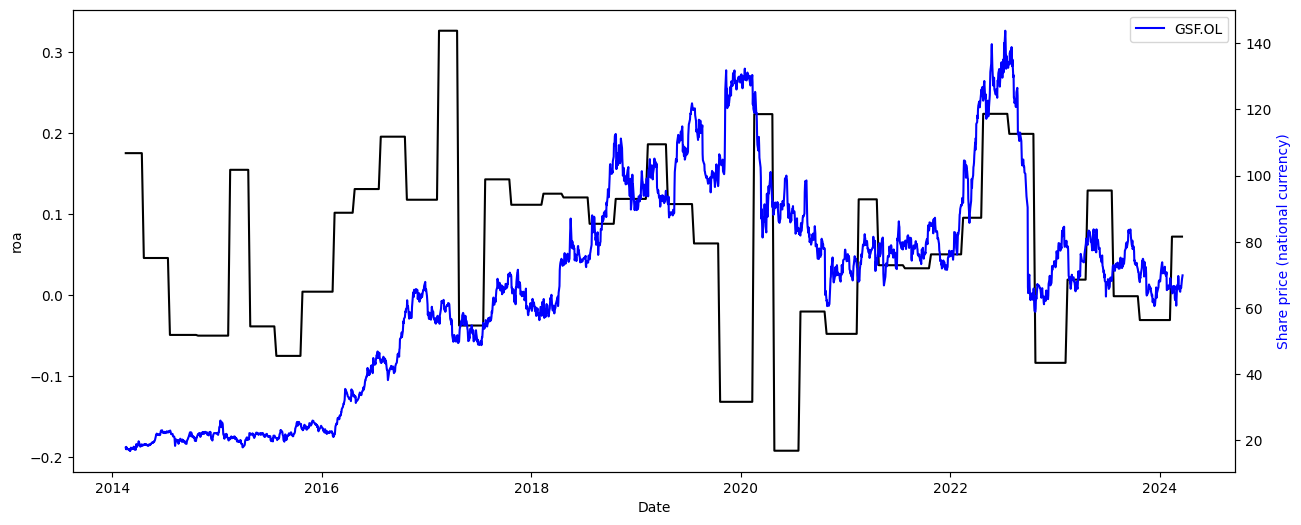

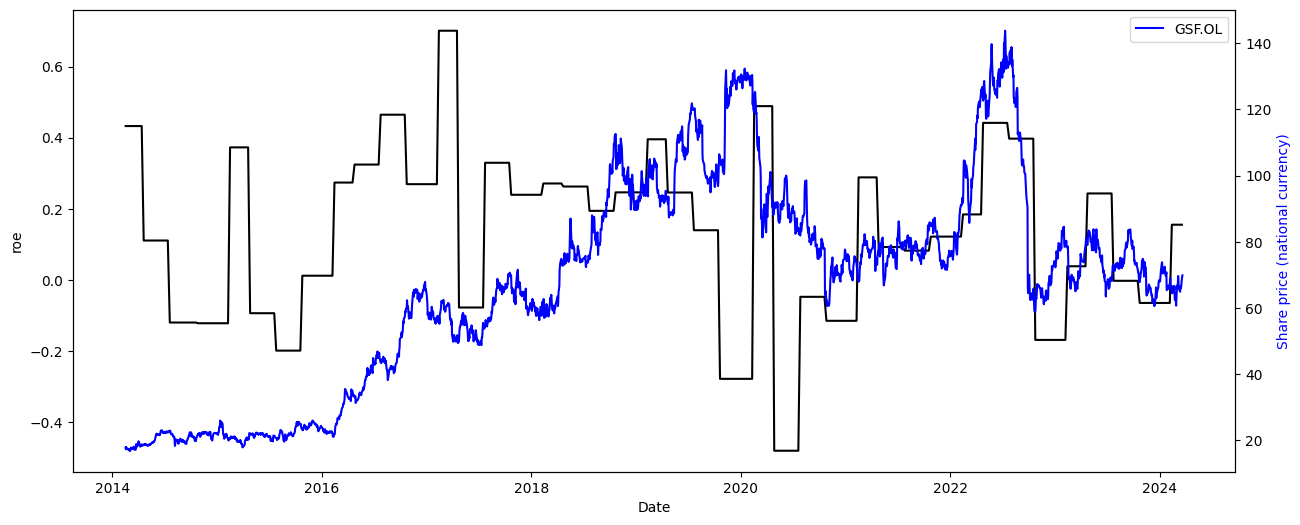

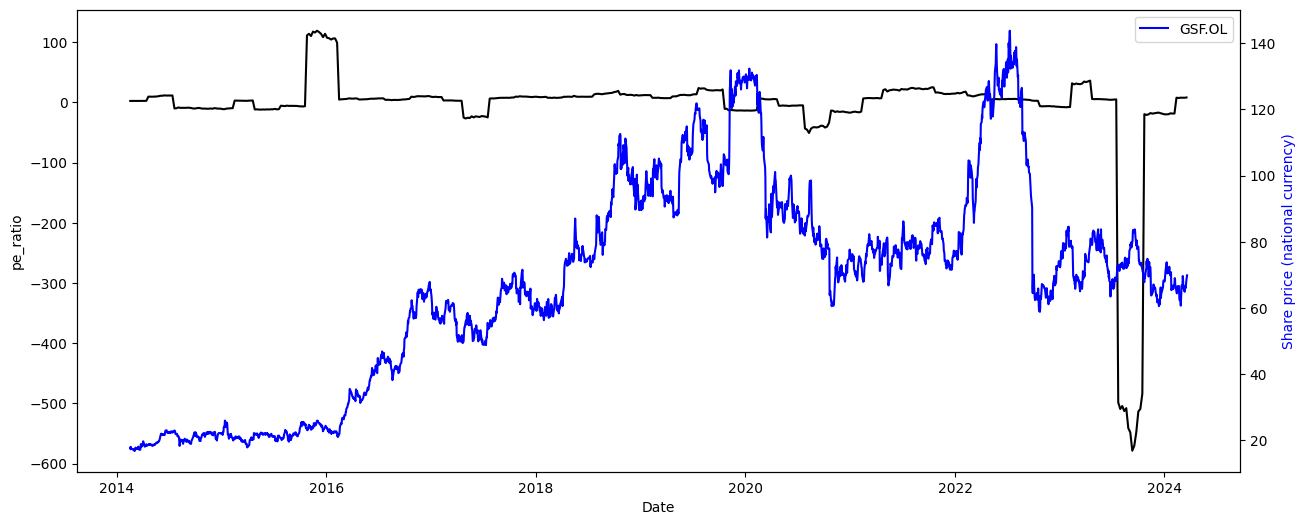

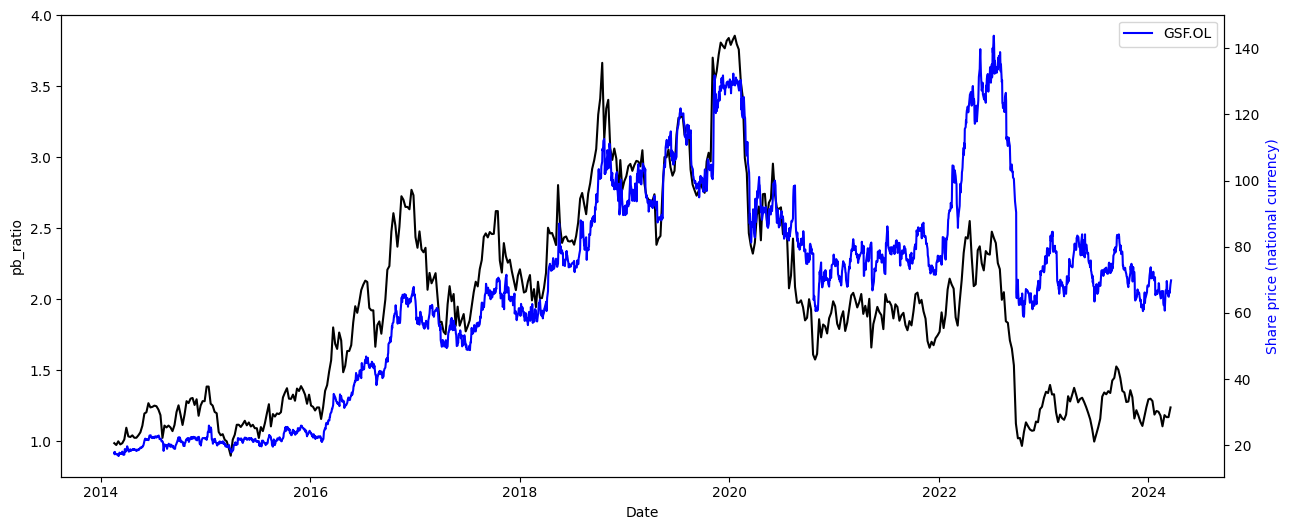

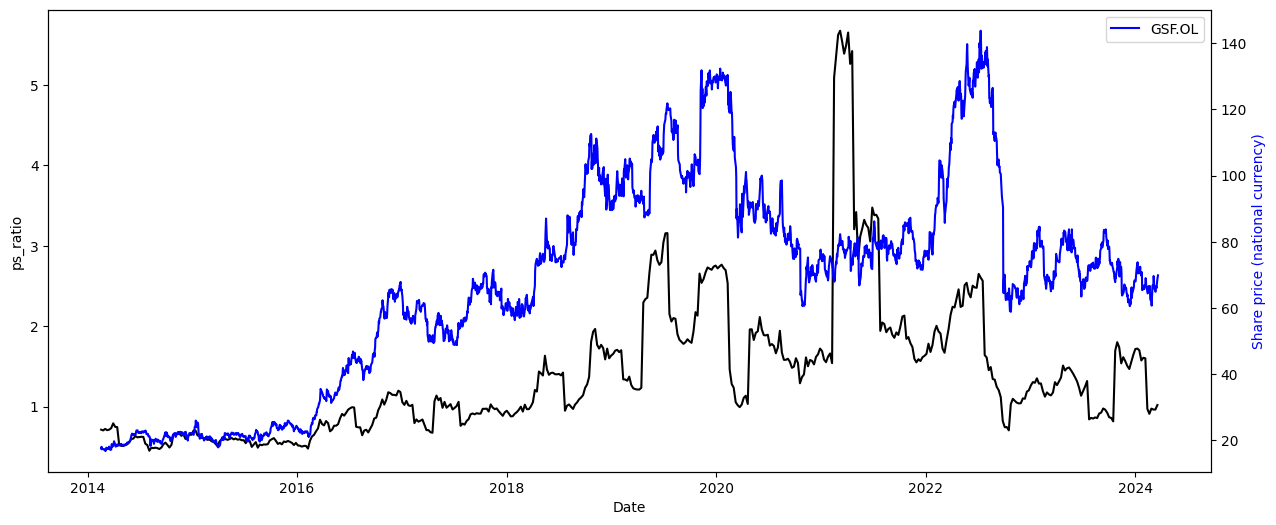

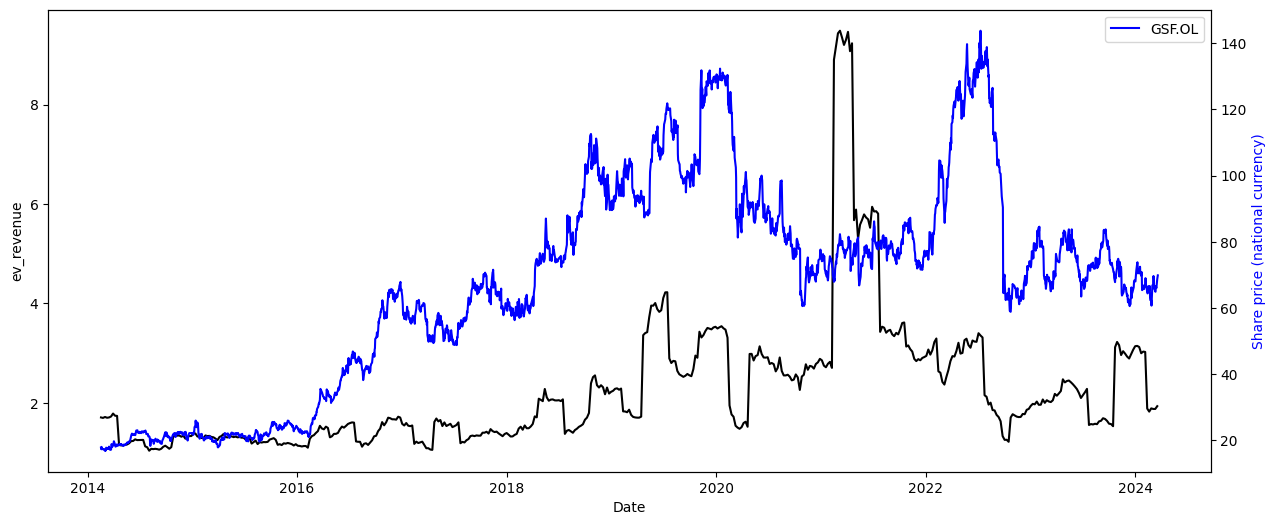

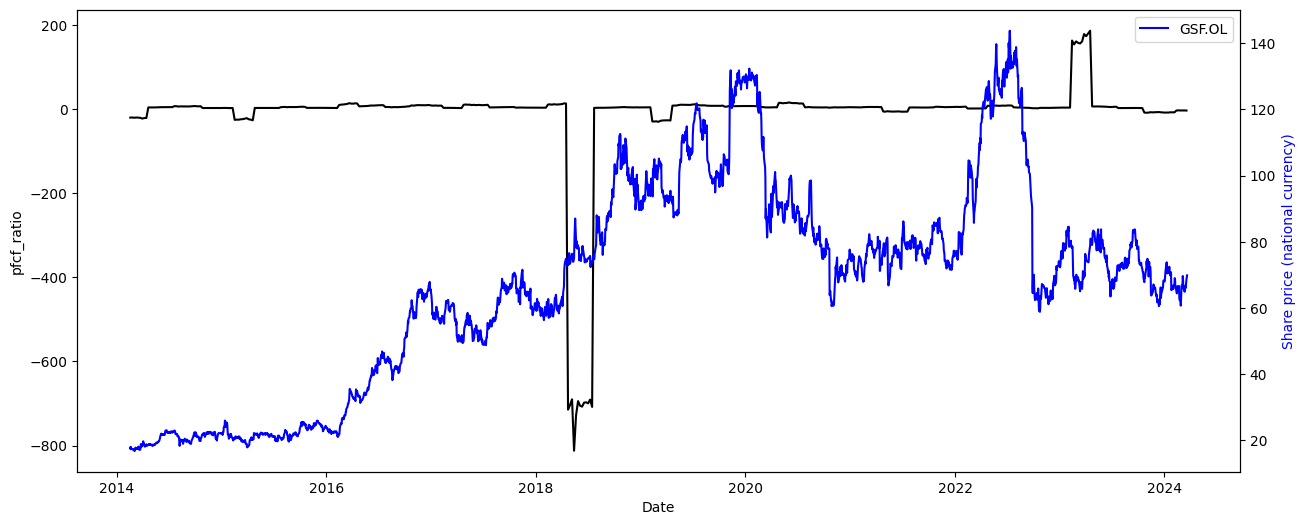

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

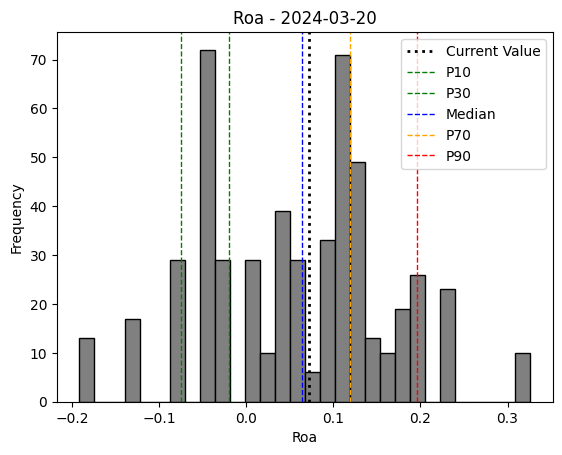

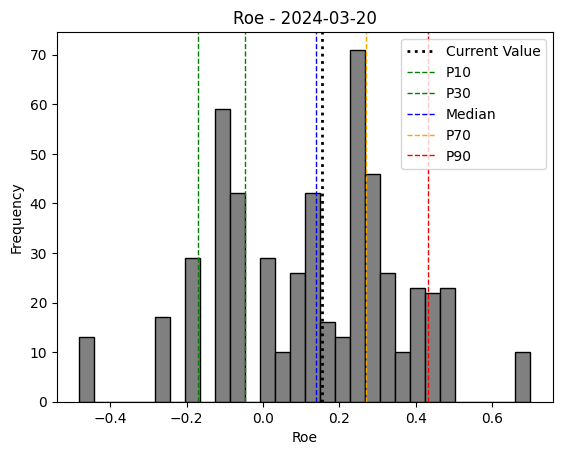

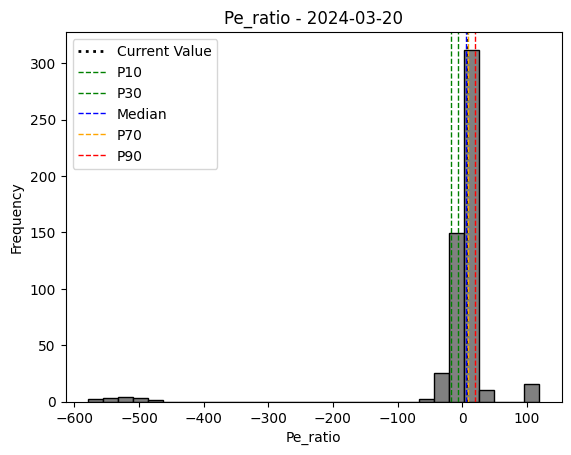

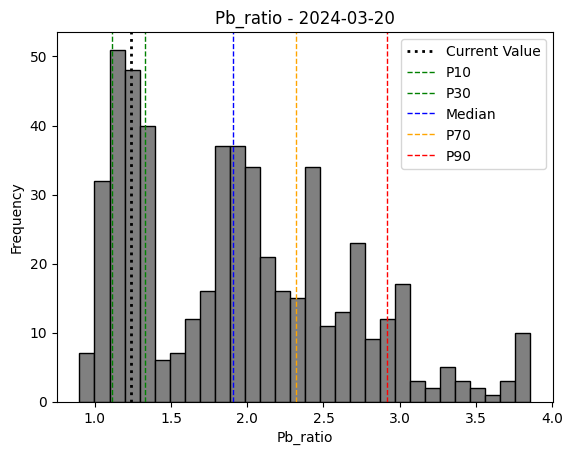

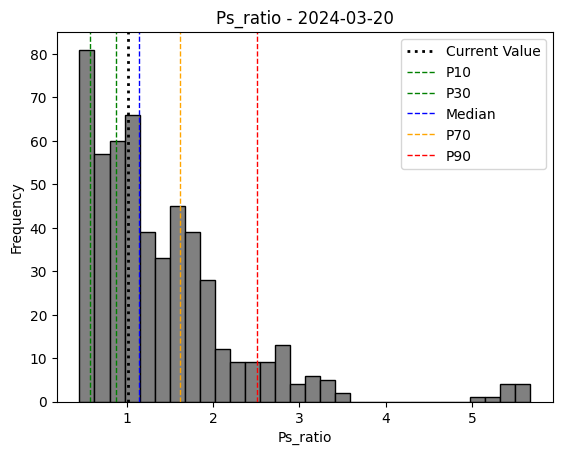

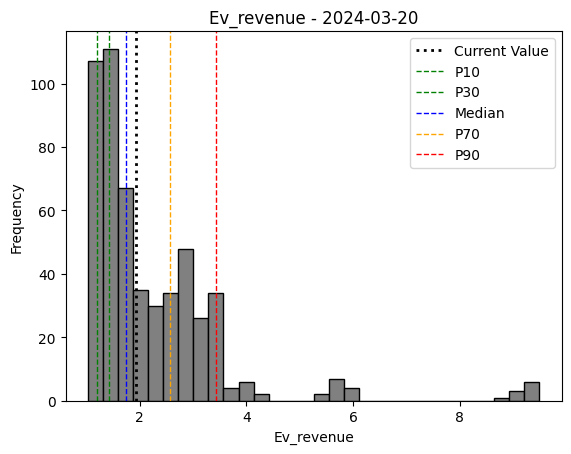

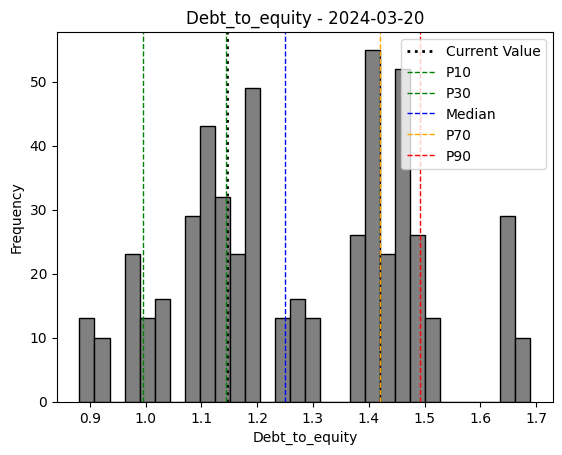

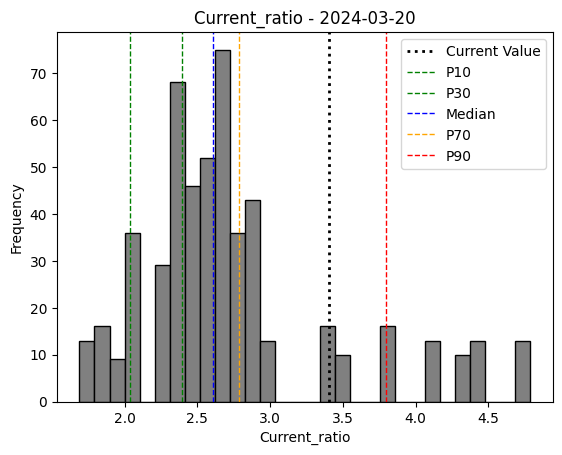

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995461,0.143738,0.130069,-0.023043,-0.070859,-0.285924,0.261544
roe,0.995461,1.000000,0.142547,0.119427,-0.025240,-0.064762,-0.248149,0.222970
pe_ratio,0.143738,0.142547,1.000000,0.114318,0.074249,0.061764,0.074786,0.033057
pb_ratio,0.130069,0.119427,0.114318,1.000000,0.449876,0.254182,-0.287668,0.069367
ps_ratio,-0.023043,-0.025240,0.074249,0.449876,1.000000,0.968552,-0.160080,0.340235
ev_revenue,-0.070859,-0.064762,0.061764,0.254182,0.968552,1.000000,-0.012917,0.243482
debt_to_equity,-0.285924,-0.248149,0.074786,-0.287668,-0.160080,-0.012917,1.000000,-0.709659
current_ratio,0.261544,0.222970,0.033057,0.069367,0.340235,0.243482,-0.709659,1.000000


6 timestemos have been found!


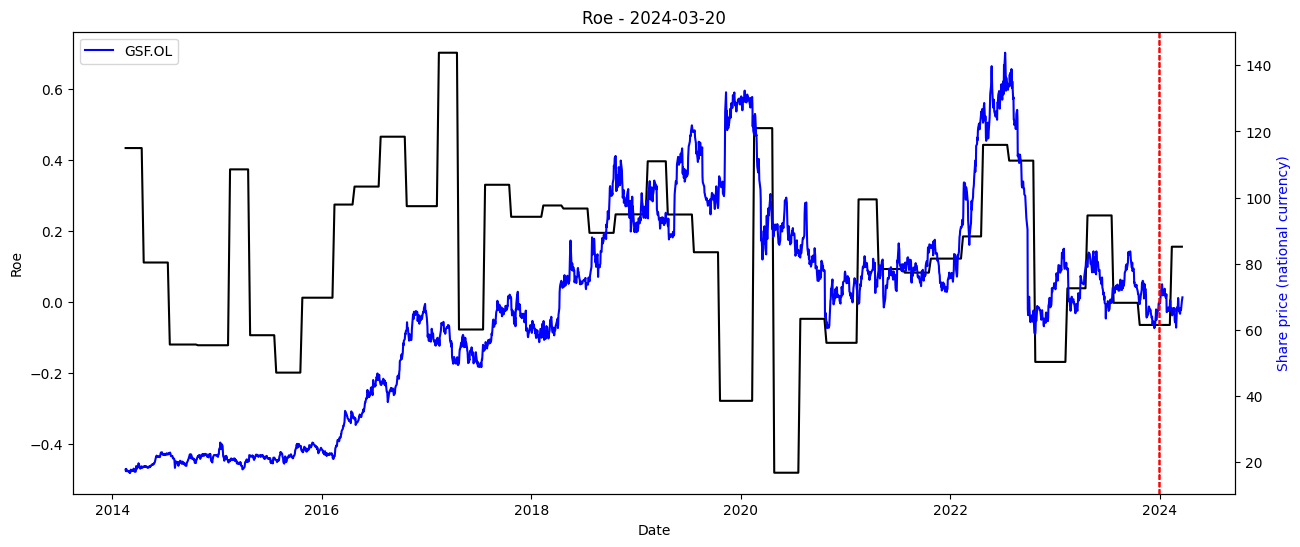

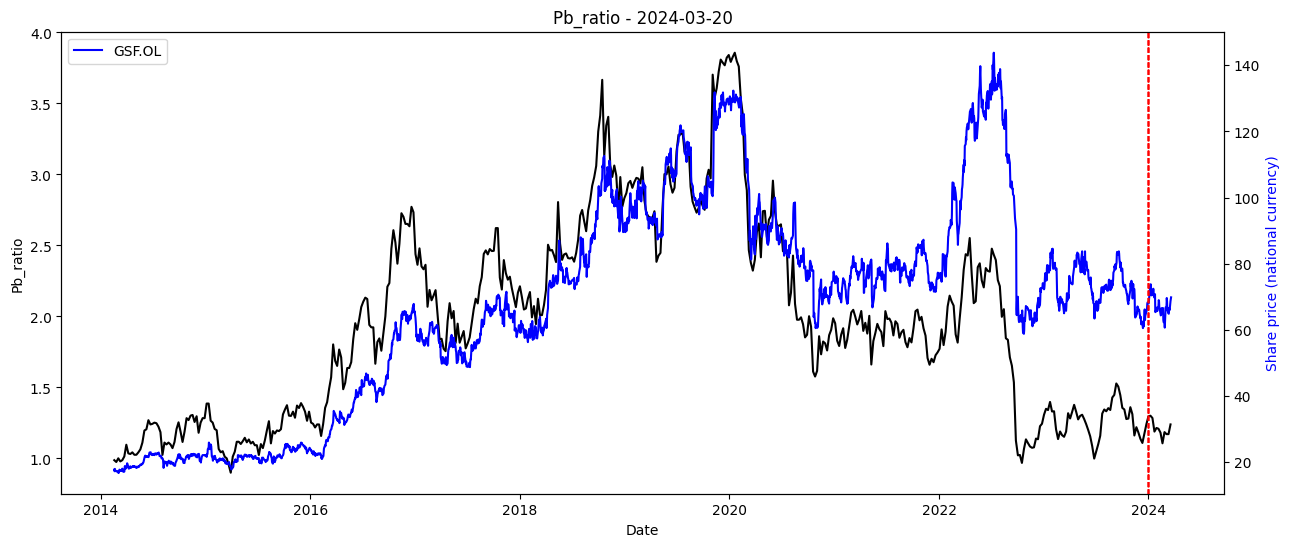

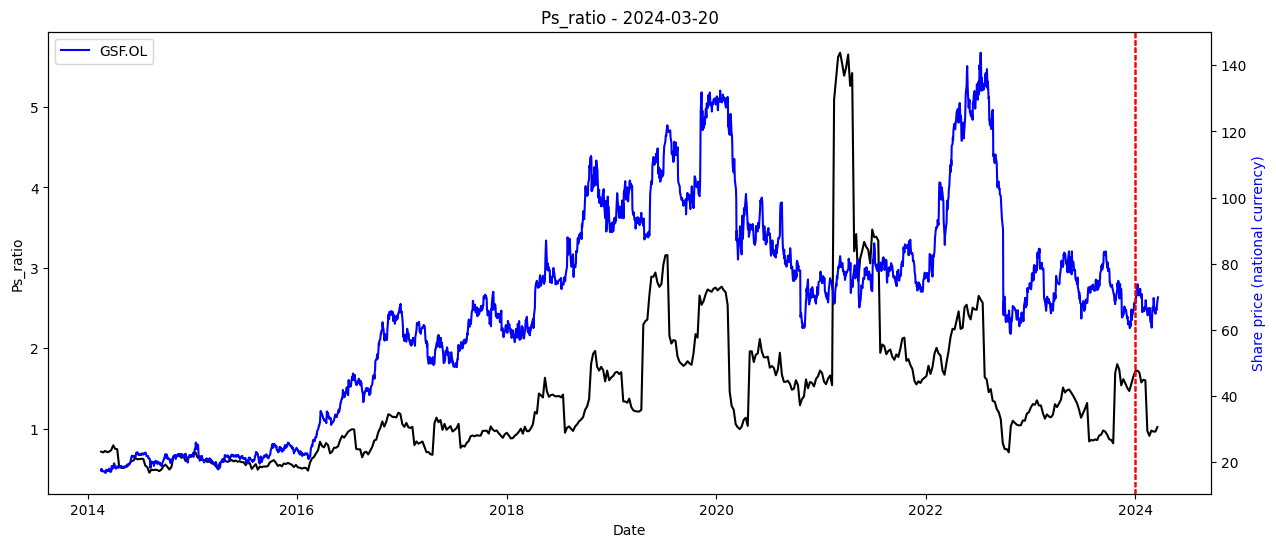

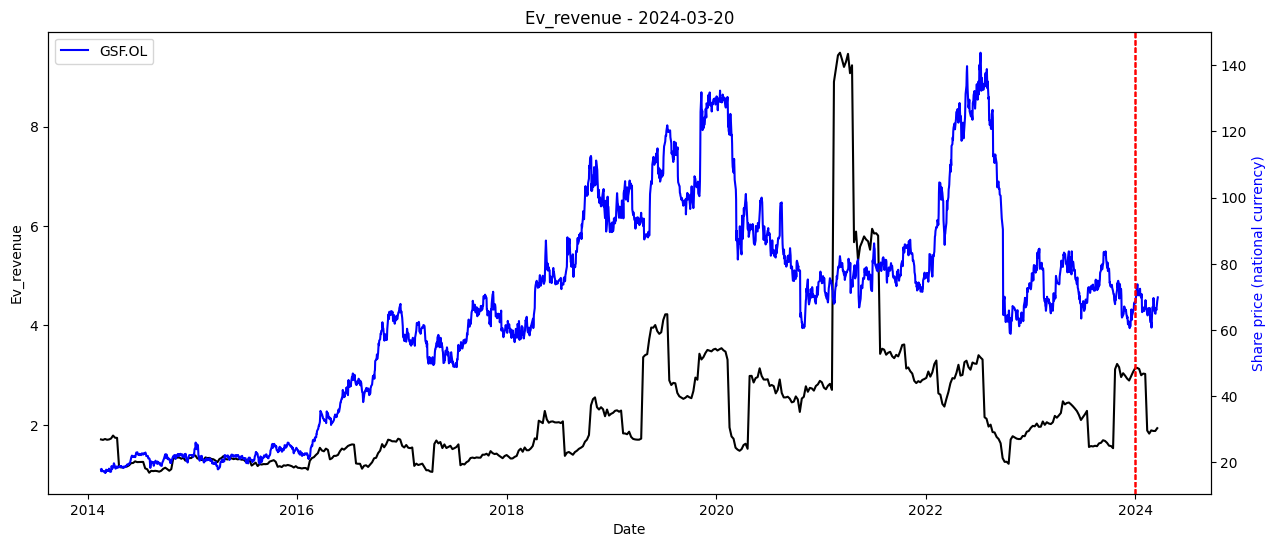

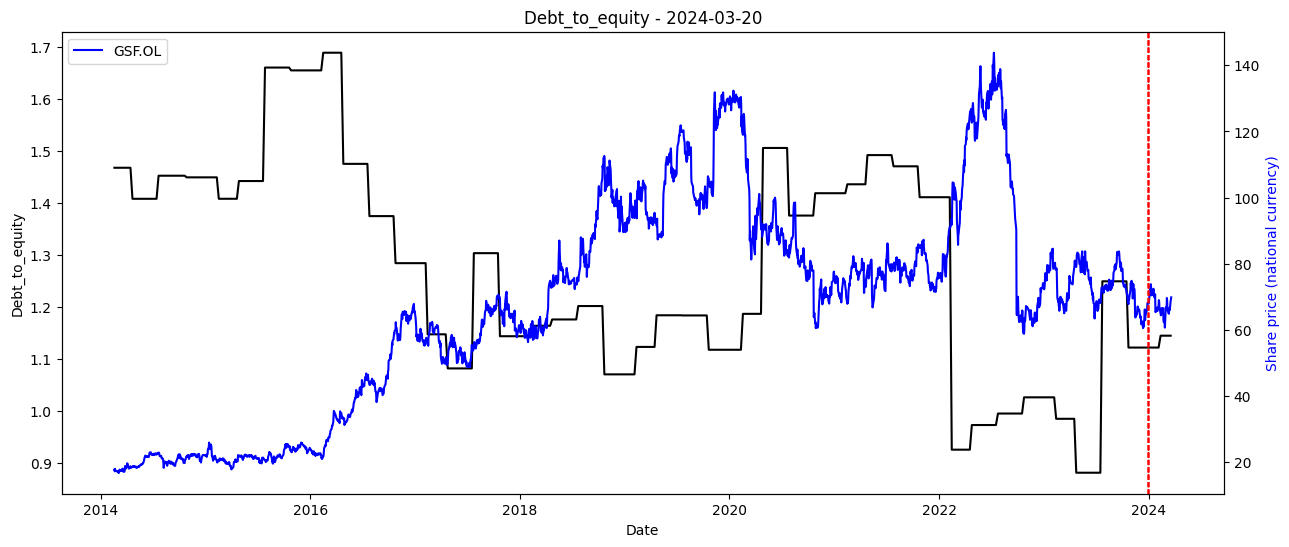

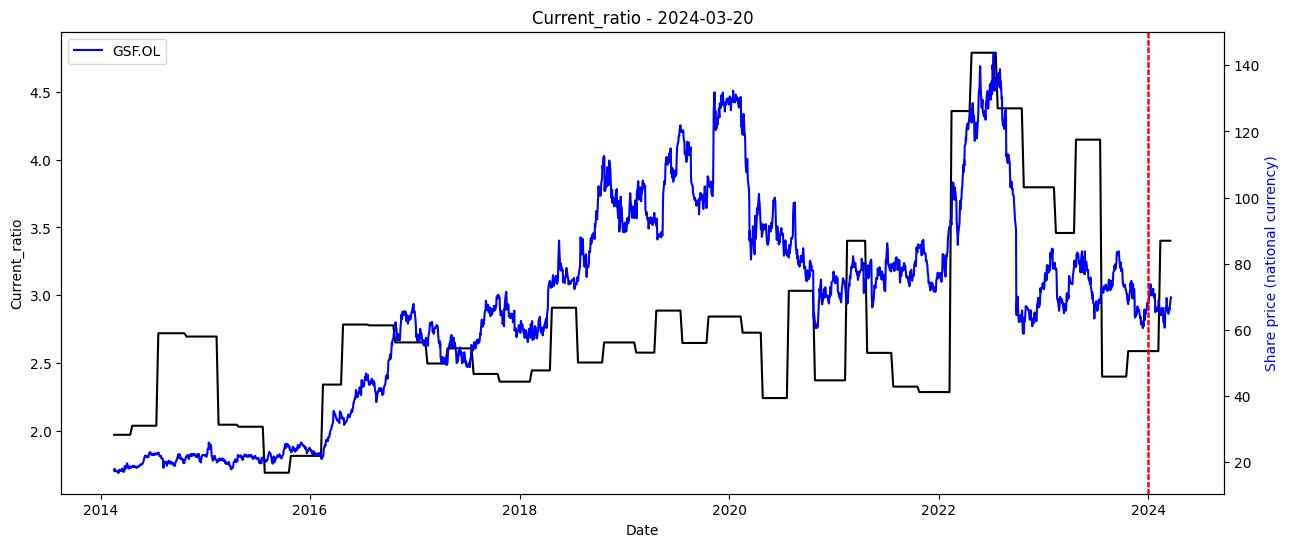

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )